In [1]:
import requests
import pandas

## Collect the nodes for a single reach

In [2]:
url = 'https://arcgis.cuahsi.org/arcgis/rest/services/SWOT/world_SWORD_nodes_mercator/FeatureServer/0/query'
f = 'json'
where = "reach_id=73252000213"
out_fields='*'

In [3]:
import urllib
params = {'f': f,
        'where': where,
        'outFields': out_fields}
#params = urllib.parse.urlencode(data, quote_via=urllib.parse.quote)
res = requests.get(url, params=params, verify=False)

/Users/castro/Documents/work/notebooks/swot/conda-env/lib/python3.12/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'arcgis.cuahsi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
nodes = []
for dat in res.json()['features']:
    nodes.append(dat['attributes']['node_id'])
nodes

[73252000210013,
 73252000210023,
 73252000210033,
 73252000210043,
 73252000210053,
 73252000210063,
 73252000210073,
 73252000210083,
 73252000210093,
 73252000210103,
 73252000210113,
 73252000210123]

## Collect data for each node in the reach

In [5]:
"""
AVAILABLE NODE FIELDS
'reach_id', 'node_id', 'time', 'time_units', 'time_tai', 'time_tai_units', 'time_str',
'lat', 'lat_units', 'lon', 'lon_units', 'lat_u', 'lat_u_units', 'lon_u', 'lon_u_units', 
'river_name', 'wse', 'wse_units', 'wse_u', 'wse_u_units', 'wse_r_u', 'wse_r_u_units', 
'width', 'width_units', 'width_u', 'width_u_units', 
'area_total', 'area_total_units', 'area_tot_u', 'area_tot_u_units', 
'area_detct', 'area_detct_units', 'area_det_u', 'area_det_u_units', 'area_wse', 'area_wse_units', 
'layovr_val', 'layovr_val_units', 'node_dist', 'node_dist_units', 'xtrk_dist', 'xtrk_dist_units',
'flow_angle', 'flow_angle_units', 'node_q', 'node_q_b',
'dark_frac', 'dark_frac_units', 'ice_clim_f', 'ice_dyn_f', 'partial_f', 
'n_good_pix', 'n_good_pix_units', 'xovr_cal_q', 
'rdr_sig0', 'rdr_sig0_units', 'rdr_sig0_u', 'rdr_sig0_u_units', 'rdr_pol', 
'geoid_hght', 'geoid_hght_units', 'solid_tide', 'solid_tide_units', 'load_tidef', 'load_tidef_units', 
'load_tideg', 'load_tideg_units', 'pole_tide', 'pole_tide_units', 
'dry_trop_c', 'dry_trop_c_units', 'wet_trop_c', 'iono_c', 'iono_c_units',
'xovr_cal_c', 'xovr_cal_c_units', 'p_wse', 'p_wse_units', 'p_wse_var', 'p_wse_var_units', 
'p_width', 'p_width_units', 'p_wid_var', 'p_wid_var_units', 
'p_dist_out', 'p_dist_out_units', 'p_length', 'p_length_units', 
'p_dam_id', 'p_dam_id_units', 'p_n_ch_max', 'p_n_ch_max_units', 'p_n_ch_mod', 'p_n_ch_mod_units', 
'cycle_id', 'pass_id', 'continent_id', 'range_start_time', 'range_end_time',
'crid', 'sword_version', 'collection_shortname','geometry'
"""

# TODO: create issue in HydroCron
# node_dist_units, xtrk_dist_units, p_dist_out_units are not valid node fields

def get_node_data(nodes):
    dat = []
    for node in nodes:
        print(f'Processing {node}')
        url = 'https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries'
        start_time='2024-01-01T00:00:00Z'
        end_time='2024-10-30T00:00:00Z'
        output='geojson'
        feature='Node'
        feature_id=node
        fields='wse,time_str,node_dist,xtrk_dist,p_dist_out,p_length'
        
        data = {'start_time': start_time,        
                'end_time': end_time , 
                'output': output,
                'fields': fields,
                'feature_id': feature_id,
                'feature':feature}
        
        res = requests.get(url, params=data)
        for d in res.json()['results']['geojson']['features']:
            dat.append([node, d['properties']['time_str'],
                        float(d['properties']['node_dist']),
                        d['properties']['node_dist_units'],
                        float(d['properties']['xtrk_dist']),
                        d['properties']['xtrk_dist_units'],
                        float(d['properties']['p_dist_out']),
                        d['properties']['p_dist_out_units'],
                        float(d['properties']['p_length']),
                        d['properties']['p_length_units'],
                        float(d['properties']['wse'])])
    return dat

In [6]:
dat = get_node_data(nodes)


Processing 73252000210013
Processing 73252000210023
Processing 73252000210033
Processing 73252000210043
Processing 73252000210053
Processing 73252000210063
Processing 73252000210073
Processing 73252000210083
Processing 73252000210093
Processing 73252000210103
Processing 73252000210113
Processing 73252000210123


In [7]:
df = pandas.DataFrame(dat, columns = ['node_id',
                                      'time_str',
                                      'node_dist',
                                      'node_dist_units',
                                      'xtrk_dist',
                                      'xtrk_dist_units',
                                      'p_dist',
                                      'p_dist_units',
                                      'p_length',
                                      'p_length_units',
                                      'wse'])

In [8]:
df['time'] = pandas.to_datetime(df.time_str)

In [9]:
import numpy as np
df.loc[df.wse < 0, 'wse'] = np.nan

In [10]:
grouped = df.groupby(df.time.dt.date)
dates = []
for name, group in grouped:
    dates.append(name)
dates

[datetime.date(2024, 1, 29),
 datetime.date(2024, 2, 9),
 datetime.date(2024, 2, 19),
 datetime.date(2024, 3, 1),
 datetime.date(2024, 3, 10),
 datetime.date(2024, 3, 11),
 datetime.date(2024, 3, 21),
 datetime.date(2024, 3, 31),
 datetime.date(2024, 4, 1),
 datetime.date(2024, 4, 11),
 datetime.date(2024, 4, 12),
 datetime.date(2024, 4, 21),
 datetime.date(2024, 4, 22),
 datetime.date(2024, 5, 2),
 datetime.date(2024, 5, 3),
 datetime.date(2024, 5, 23)]

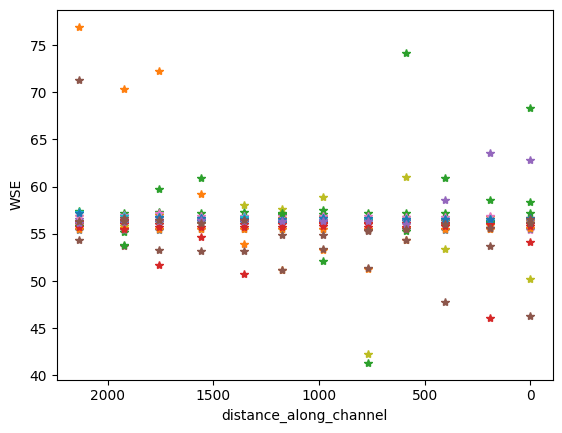

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

node_dat = list(grouped)
for node in node_dat:
    dat = node[1]
    # convert x-axis into distance along channel instead of distance to outlet
    outlet_distance = dat.p_dist.min()
    dat['distance_along_channel'] = dat.p_dist - outlet_distance
    dat.sort_values(by='distance_along_channel', inplace=True)
    dat.plot(x='distance_along_channel', y='wse', style='*', ax=ax)

plt.gca().invert_xaxis()
ax.get_legend().remove()
ax.set_ylabel('WSE');

In [22]:
# convert x-axis into distance along channel instead of distance to outlet
outlet_distance = dat.p_dist.min()
dat['distance_along_channel'] = dat.p_dist - outlet_distance

In [23]:
# reverse the x-axis to the outlet of the channel is always on the right. This is intuitive since we read left to right.




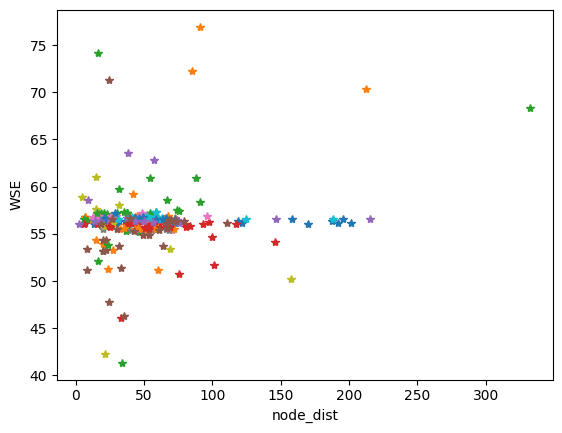

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

node_dat = list(grouped)
for node in node_dat:
    dat = node[1]
    dat.sort_values(by='node_dist', inplace=True)
    dat.plot(x='node_dist', y='wse', style='*', ax=ax)
ax.get_legend().remove()
ax.set_ylabel('WSE');


In [14]:
node_dat = list(grouped)[5][1]

In [15]:
# node_dat['node_dist'] = node_dat.node_dist.astype(float)
# node_dat['wse'] = node_dat.wse.astype(float)

<Axes: xlabel='node_dist'>

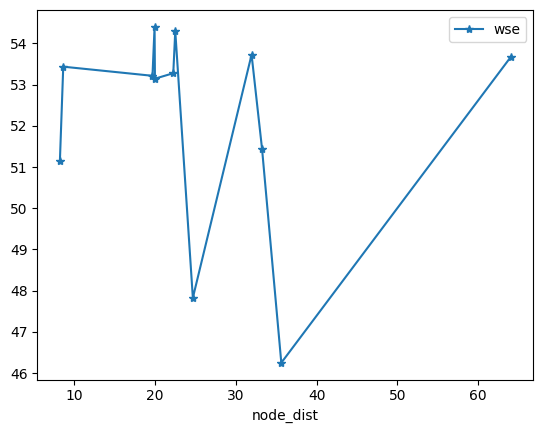

In [16]:
node_dat.sort_values(by='node_dist', inplace=True)
node_dat.plot(x='node_dist', y='wse', style='*-')

<Axes: xlabel='xtrk_dist'>

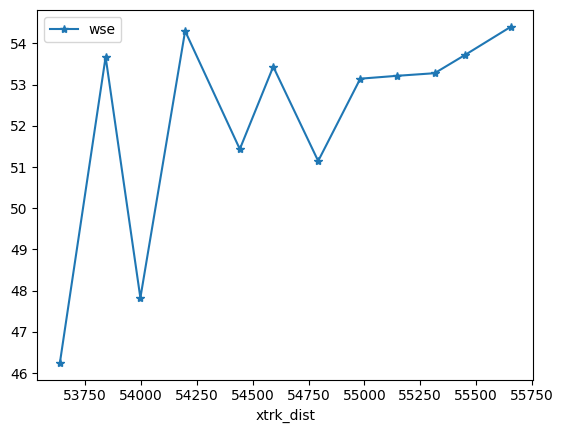

In [17]:
node_dat.sort_values(by='xtrk_dist', inplace=True)
node_dat.plot(x='xtrk_dist', y='wse', style='*-')

<Axes: xlabel='p_dist'>

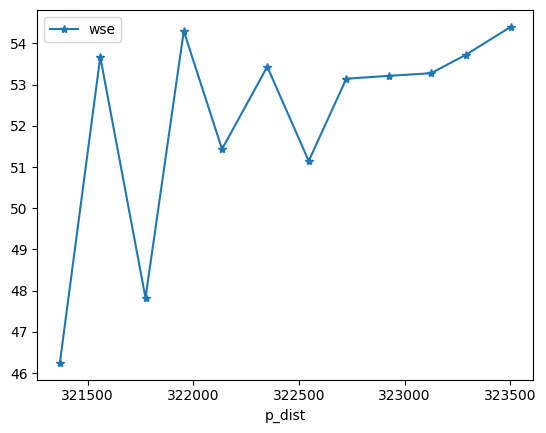

In [18]:
node_dat.sort_values(by='p_dist', inplace=True)
node_dat.plot(x='p_dist', y='wse', style='*-')

<Axes: xlabel='p_length'>

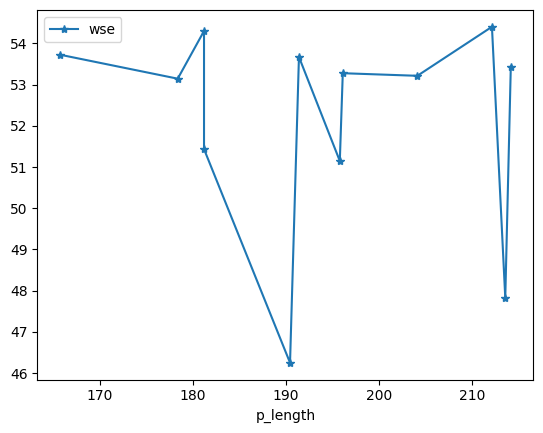

In [19]:
node_dat.sort_values(by='p_length', ascending=True, inplace=True)
node_dat.plot(x='p_length', y='wse', style='*-')